# Artificial Neural Networks with TensorFlow.Keras

In this notebook we will see how to use TensorFlow to train ANNs and avoid needing to extract features like we did in the previous notebook. We will first translate the data into test and training sets, and then try to fit the model using a simple neural network.

In [ ]:
# Grab the same digit data we used before
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4185, done.
remote: Counting objects: 100% (513/513), done.
remote: Compressing objects: 100% (513/513), done.
remote: Total 4185 (delta 4), reused 501 (delta 0), pack-reused 3672
Receiving objects: 100% (4185/4185), 30.44 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Checking out files: 100% (3012/3012), done.


In [ ]:
#Change directories
import os
os.chdir('free-spoken-digit-dataset/recordings')

In [ ]:
#Put all wav file names in a list

import glob, os

wavfiles = list()
for file in glob.glob("*.wav"):
    wavfiles.append(file)

n_audio_samples = len(wavfiles)

print('{} audio samples\n'.format(n_audio_samples))

# list the first few files
wavfiles[:10]


3000 audio samples



['3_george_12.wav',
 '4_lucas_6.wav',
 '7_george_11.wav',
 '8_lucas_23.wav',
 '2_yweweler_33.wav',
 '5_george_1.wav',
 '4_yweweler_45.wav',
 '6_theo_23.wav',
 '3_yweweler_19.wav',
 '6_yweweler_8.wav']

In [ ]:
#Import modules that we plan on using for training and plotting results

import numpy as np
import scipy.io.wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn import metrics

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})


2021-07-13 21:51:15.601018: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-13 21:51:15.601094: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load the data from audio files into variables

In [ ]:
#Load regular expression module so we can get speaker name and spoken digit 
#from each file name and use those to create labels for the data

#Note: regular expressions are not just a python thing, they represent a general
#method to check if strings match a general pattern, and return desired portions
#of that match. In this case, we are using regular expressions to get the digit,
#speaker, and trial number from each file's name, knowing that the format of 
#each file name fits the form "<digit>_<speaker>_<trial_num>.wav".

import re

re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d+.')

In [ ]:
#Iterate over each data file to put the signal data samples into each element of
#X_data. Then populate the lists of speaker labels and digit labels based on each
#file name (y_speaker_labels and y_digit_labels, respectively)

X_data = np.ndarray(shape=(n_audio_samples,),dtype=object)
y_speaker_labels = list()
y_digit_labels = list()

for ind, sample_file in enumerate(wavfiles):
  try:

    #Get digit and speaker from this sample    
    digit = int(re.match( re_digit, sample_file)[0][:-1])
    speaker = re.search( re_speaker, sample_file)[0][1:-1]

    # read in data from file
    (sample_rate, signal) = scipy.io.wavfile.read(sample_file)
    
    # some files have two channels... just take the first one
    if len(signal.shape) == 2:
      signal = signal[:,0]

    #Load the sample data into row <ind> of X_data
    X_data[ind,] = np.array(signal)
    
    #Load speaker and digit into their respective lists
    y_speaker_labels.append(speaker)
    y_digit_labels.append(digit)

  except Exception as e:
    
    # something went wrong!  =(
    
    print(sample_file)
    print(e)
    print(X_data.shape)
    print(signal.shape)
    
    break

## Standardize the length of audio inputs
Each .wav file is a different duration.  The artificial neural net we are building will expect inputs to be of the same size.  Let's artifically pad or truncate our input vectors so they're all the same length.  (Warning: we may lose data!)

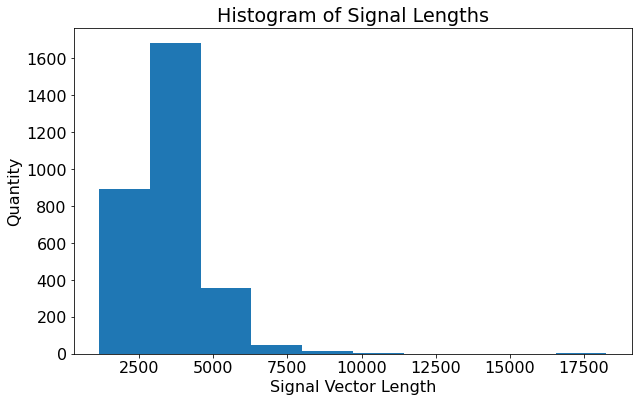

In [ ]:
#Let's look at how long the signal vectors are to see what a good "standard length" might be

plt.figure()
plt.hist([len(x) for x in X_data])
plt.xlabel('Signal Vector Length')
plt.ylabel('Quantity')
plt.title('Histogram of Signal Lengths')

X_data_untrimmed = X_data.copy() #store old X_data before we overwrite

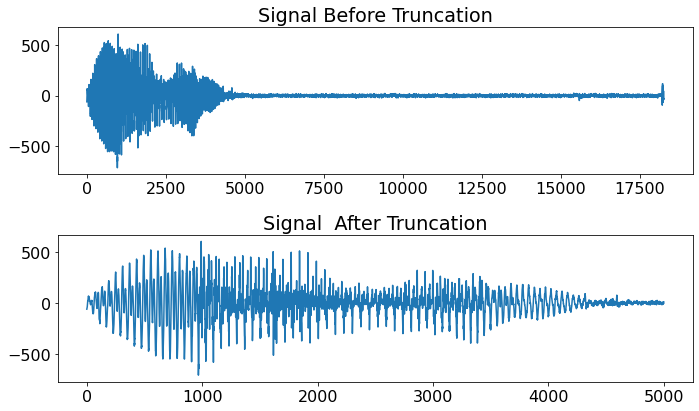

In [ ]:
#Let's standardize inputs to length 5000 in light of the above histogram

desired_length = 5000

for ix in range(X_data.shape[0]): #iterate over elements in X_data
  
  if X_data[ix].shape[0] < desired_length:
    pad_len = desired_length - X_data[ix].shape[0]
    X_data[ix] = np.append(X_data[ix],np.mean(X_data[ix])*np.ones(pad_len))
    
  elif X_data[ix].shape[0] > desired_length:
    X_data[ix] = X_data[ix][:desired_length]
    
  # remove the mean
  X_data[ix] = X_data[ix]-np.mean(X_data[ix])

s_plot_ix = max(range(len(X_data_untrimmed)),
                key = lambda x:len(X_data_untrimmed[x]))   # get element with max length (for demonstration)
plt.subplot(2,1,1)
plt.plot(X_data_untrimmed[s_plot_ix])
plt.title('Signal Before Truncation')

plt.subplot(2,1,2)
plt.plot(X_data[s_plot_ix])
plt.title('Signal  After Truncation')

#make sure text doesn't overlap between plots
plt.tight_layout()            

In [ ]:
# Change the elements of y_labels vector into integers (currently they are strings) 
# and make y_labels into a np.array
# (so we can manipulate it similarly to X_labels)

# Set y_labels based on what output (speaker or digit) you want the network to learn
y_labels = y_speaker_labels.copy()

#convert labels into integers (needed to convert y_labels to one_hot encoding)
name2int_dict = {x: i for i, x in enumerate(set(y_labels))}

y_labels = np.array([name2int_dict[label] for label in y_labels]) #ylabels now are all integers

print('Old y_labels (strings in list):')
print(y_speaker_labels[:10])
print('\n')

print('New y_labels (integers in numpy array):')
print(y_labels[:10])


Old y_labels (strings in list):
['george', 'lucas', 'george', 'lucas', 'yweweler', 'george', 'yweweler', 'theo', 'yweweler', 'yweweler']


New y_labels (integers in numpy array):
[1 2 1 2 0 1 0 5 0 0]


## Split data into test/train split

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# split X and y into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_data, np.array(y_labels), test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.25)

print(f'Data has been split into {len(y_train)} train sampes and {len(y_test)} test samples')

Data has been split into 2250 train sampes and 750 test samples


## Reformat the labels

Next, we want to convert the labels from an integer format (e.g., "2"), to a [one hot encoding](https://en.wikipedia.org/wiki/One-hot) (e.g., "0, 0, 1, 0, 0, 0, 0, 0, 0, 0"). To do so, we'll use the `tf.keras.utils.to_categorical` [function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [ ]:
n_classes = max(set(y_labels))+1 # Get number of distinct classes so we know how large to make the plot

print("Before", y_train[0]) # The format of the labels before conversion

y_train  = tf.keras.utils.to_categorical(y_train, n_classes)

print("After", y_train[0]) # The format of the labels after conversion

y_test = tf.keras.utils.to_categorical(y_test, n_classes)

Before 2
After [0. 0. 1. 0. 0. 0.]


## Build the model

Now, we'll create our neural network using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). 
* Architecture wise, we'll single layer network. 
* The hidden layer will have 128 units using the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation function. 
* The output layer will have 10 units and use [softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) function. 
* Notice, we specify the input shape on the first layer. If you add subsequent layers, this is not necessary. 
* We will use the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) loss function, and the [RMSProp](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) optimizer.

In [ ]:
X_train_df = pd.DataFrame()
for xx in X_train:
  X_train_df=X_train_df.append(pd.Series(xx),ignore_index=True)


X_test_df = pd.DataFrame()
for xx in X_test:
  X_test_df=X_test_df.append(pd.Series(xx),ignore_index=True)

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=X_train[0].shape))
model.add(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))

# We will now compile and print out a summary of our model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160032    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 160,230
Trainable params: 160,230
Non-trainable params: 0
_________________________________________________________________
2021-07-13 21:52:12.975483: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-13 21:52:12.975693: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-13 21:52:12.975706: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-13 21:52:12.975731: I t

## Training

Next, we will train the model by using the [fit method](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for 10 epochs (an epoch is one pass through the data). We will keep track of the training loss and accuracy as we go. Please be patient as this step may take a while depending on your hardware.

2021-07-13 21:52:13.131378: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 90000000 exceeds 10% of free system memory.
2021-07-13 21:52:13.229280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-13 21:52:13.249136: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
Epoch 1/10
71/71 [==============================] - 1s 3ms/step - loss: 2404.8710 - accuracy: 0.2080
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 559.2744 - accuracy: 0.4799
Epoch 3/10
71/71 [==============================] - 0s 3ms/step - loss: 375.9784 - accuracy: 0.5542
Epoch 4/10
71/71 [==============================] - 0s 3ms/step - loss: 288.9577 - accuracy: 0.6336
Epoch 5/10
71/71 [==============================] - 0s 3ms/step - loss: 206.6244 - accuracy: 0.7137
Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 143.0316 - accu

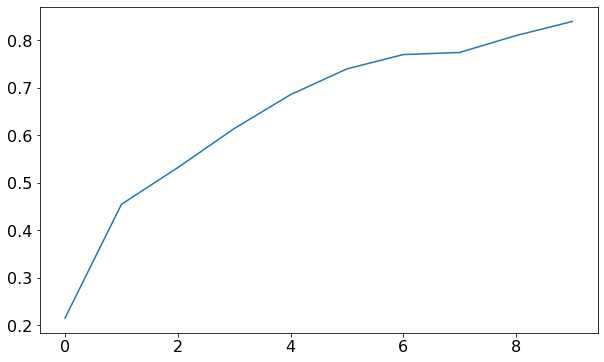

In [ ]:
history = model.fit(X_train_df, y_train, epochs=10)

# plot metrics
plt.plot(history.history['accuracy'])
plt.show()

## Testing
Now that we have trained our model, we want to evaluate it. The training accuracy was quite high great (88%, depending on the random seed), but some of this could be due to overfitting the input dataset.  Let's see how well we do on our test data.

In [ ]:
# We can check our model's metrics by using the model.evaluate function and 
# providing the test data and labels as inputs

loss, accuracy = model.evaluate(X_test_df, y_test)
print('Test accuracy: %.2f' % (accuracy))

24/24 [==============================] - 0s 2ms/step - loss: 2050.8142 - accuracy: 0.3440
Test accuracy: 0.34
2021-07-13 21:52:16.084771: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30000000 exceeds 10% of free system memory.


In [ ]:
# We can also calculate what the model predicts on the test data using the
# model.predict function and providing the test data as input
# (Note that the prediction is a one-)
y_pred = model.predict(X_test_df, verbose=1)


24/24 [==============================] - 0s 1ms/step
2021-07-13 21:54:31.573020: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30000000 exceeds 10% of free system memory.


## Having built a model (albeit overfit), let's plot its confusion matrix

In [ ]:
# Populate two lists to build our confusion matrix
# ix_pred is a list of all the predictions of the classifier (as integers)
# ix_true is a list of all true labels of the classifier (as integers)

ix_pred = [np.argmax(y) for y in y_pred]
ix_true = [np.argmax(y) for y in y_test]

# Create function to visualize the confusion matrix

int2name_dict = {val: key for key, val in name2int_dict.items()}

import seaborn as sns

def plot_cmatrix(cm,labels,title='Confusion Matrix', **kwargs):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = sns.heatmap(cm, **kwargs)
  plt.title('\n'+title+'\n', fontsize=20)
  # fig.colorbar(cax)
  ax.set_xticks(np.arange(len(labels))+0.5)
  ax.set_yticks(np.arange(len(labels))+0.5)
  ax.set_xticklabels([int2name_dict[label] for label in labels], fontsize=16)
  ax.set_yticklabels([int2name_dict[label] for label in labels], fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.yticks(rotation=0)
  plt.show()
  

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=range(0, 6) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


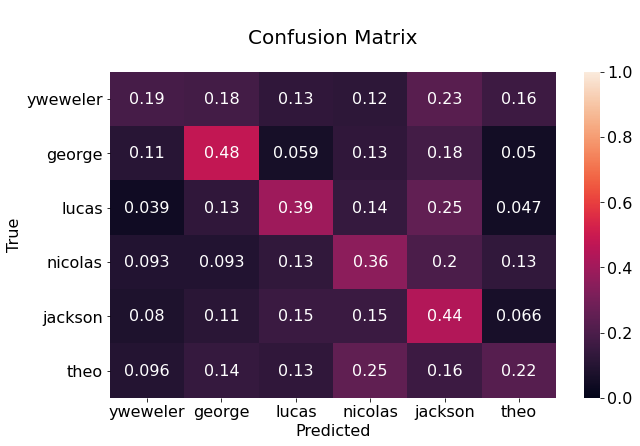

In [ ]:
cm = metrics.confusion_matrix(ix_true,ix_pred, range(n_classes), normalize = 'true')
plot_cmatrix(cm, range(n_classes), vmax = 0, vmin = 1, annot = True)


### Conclusions
As you can see, this is actually a pretty terrible classifier!
* Play around with some of the model parameters to see if you can make it better.  Later we'll see how we can use convolutions to solve a similar problem!
* You could also try to see if you can train a better classifier using the frequency spectrum instead of the raw signal

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6ef38b-230b-4598-a65d-031c49606565' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>